# HW6  - Discrete environment / algorithm
# Arian mohammadkhani - 810603136 

In [1]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [2]:
class SimpleMountainCarEnv:
    def __init__(self):
        self.position_bounds = [-1.2, 0.6]
        self.velocity_bounds = [-0.07, 0.07]
        self.force = 0.001
        self.gravity = 0.0025
        self.max_steps = 200
        self.reset()

    def reset(self):
        self.position = np.random.uniform(-0.6, -0.4)
        self.velocity = 0.0
        self.steps = 0
        return np.array([self.position, self.velocity])

    def step(self, action):
        force_effect = (action - 1) * self.force
        gravity_effect = -np.cos(3 * self.position) * self.gravity

        self.velocity += force_effect + gravity_effect
        self.velocity = np.clip(self.velocity, *self.velocity_bounds)

        self.position += self.velocity
        self.position = np.clip(self.position, *self.position_bounds)

        if self.position in self.position_bounds:
            self.velocity = 0.0

        self.steps += 1
        done = False
        reward = -1

        if self.position >= 0.5:
            done = True
            reward = 1

        if self.steps >= self.max_steps:
            done = True

        return np.array([self.position, self.velocity]), reward, done

In [3]:
n_position_buckets = 30
n_velocity_buckets = 30

def discretize_state(state):
    position, velocity = state
    pos_scale = (position - (-1.2)) / (0.6 - (-1.2))
    vel_scale = (velocity - (-0.07)) / (0.07 - (-0.07))

    pos_bucket = int(pos_scale * (n_position_buckets - 1))
    vel_bucket = int(vel_scale * (n_velocity_buckets - 1))

    pos_bucket = min(n_position_buckets - 1, max(0, pos_bucket))
    vel_bucket = min(n_velocity_buckets - 1, max(0, vel_bucket))

    return (pos_bucket, vel_bucket)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

In [4]:
def train_q_learning():
    env = SimpleMountainCarEnv()
    q_table = np.zeros((n_position_buckets, n_velocity_buckets, 3))
    episode_rewards = []

    alpha = 0.1
    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.999
    epsilon_min = 0.05
    n_episodes = 10000

    start_time = time.time()

    for episode in range(n_episodes):
        state_continuous = env.reset()
        state_disc = discretize_state(state_continuous)
        total_reward = 0
        done = False

        while not done:
            if np.random.random() < epsilon:
                action = np.random.choice([0, 1, 2])
            else:
                action = np.argmax(q_table[state_disc])

            next_state_continuous, reward, done = env.step(action)
            next_state_disc = discretize_state(next_state_continuous)

            best_next_action = np.argmax(q_table[next_state_disc])
            td_target = reward + gamma * q_table[next_state_disc + (best_next_action,)]
            td_error = td_target - q_table[state_disc + (action,)]
            q_table[state_disc + (action,)] += alpha * td_error

            state_disc = next_state_disc
            total_reward += reward

        episode_rewards.append(total_reward)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        if (episode + 1) % 1000 == 0:
            print(f"Q-learning Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    end_time = time.time()
    print(f"Q-learning Training finished! Time elapsed: {end_time - start_time:.2f} seconds")
    return q_table, episode_rewards

In [5]:
def evaluate_q_learning_visual(q_table):
    env_eval = gym.make("MountainCar-v0", render_mode="human")
    state, _ = env_eval.reset()
    state_disc = discretize_state(state)
    done = False
    total_reward = 0

    while not done:
        action = np.argmax(q_table[state_disc])
        next_state, reward, terminated, truncated, _ = env_eval.step(action)
        done = terminated or truncated
        state_disc = discretize_state(next_state)
        total_reward += reward
        env_eval.render()
        time.sleep(0.01)

    print(f"\nFinal Evaluation Total Reward (Q-learning): {total_reward}")
    env_eval.close()

def evaluate_q_learning(q_table, n_runs=10):
    env = gym.make("MountainCar-v0")
    steps_list = []

    for _ in range(n_runs):
        state = env.reset()
        state = state[0] if isinstance(state, tuple) else state
        state_disc = discretize_state(state)
        done = False
        steps = 0

        while not done and steps < 200:
            action = np.argmax(q_table[state_disc])
            result = env.step(action)

            if len(result) == 5:
                next_state, _, terminated, truncated, _ = result
                done = terminated or truncated
            else:
                next_state, _, done, _ = result

            state_disc = discretize_state(next_state)
            steps += 1

        steps_list.append(steps)

    env.close()
    return np.mean(steps_list)

Q-learning Episode 1000, Total Reward: -200, Epsilon: 0.368
Q-learning Episode 2000, Total Reward: -200, Epsilon: 0.135
Q-learning Episode 3000, Total Reward: -190, Epsilon: 0.050
Q-learning Episode 4000, Total Reward: -153, Epsilon: 0.050
Q-learning Episode 5000, Total Reward: -200, Epsilon: 0.050
Q-learning Episode 6000, Total Reward: -145, Epsilon: 0.050
Q-learning Episode 7000, Total Reward: -161, Epsilon: 0.050
Q-learning Episode 8000, Total Reward: -143, Epsilon: 0.050
Q-learning Episode 9000, Total Reward: -148, Epsilon: 0.050
Q-learning Episode 10000, Total Reward: -109, Epsilon: 0.050
Q-learning Training finished! Time elapsed: 25.77 seconds

Final Evaluation Total Reward (Q-learning): -143.0


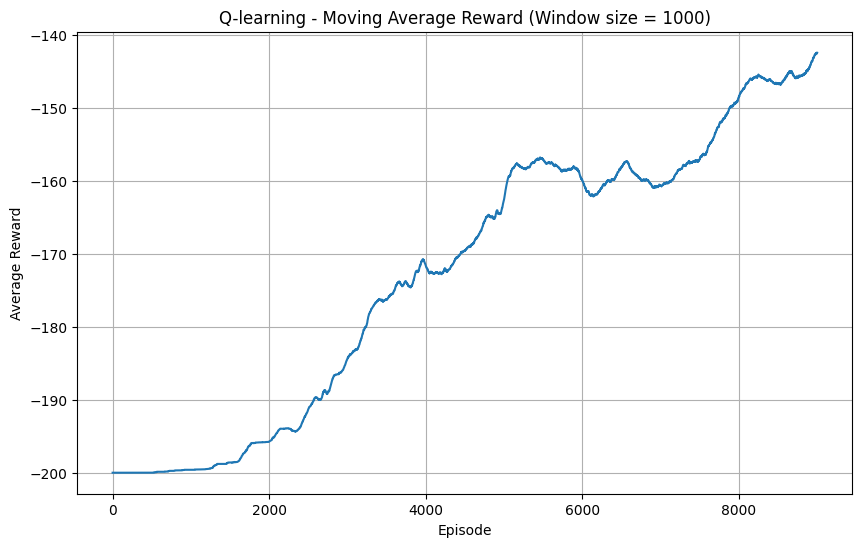


Average steps over evaluation runs: 131.6


In [6]:
if __name__ == "__main__":
    q_table, reward_history = train_q_learning()
    evaluate_q_learning_visual(q_table)
    avg_steps = evaluate_q_learning(q_table)
    window = 1000
    moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(10, 6))
    plt.plot(moving_avg)
    plt.title(f"Q-learning - Moving Average Reward (Window size = {window})")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.show()
    print(f"\nAverage steps over evaluation runs: {avg_steps}")

In [7]:
def train_double_q_learning():
    q_table_1 = np.zeros((n_position_buckets, n_velocity_buckets, 3))
    q_table_2 = np.zeros((n_position_buckets, n_velocity_buckets, 3))
    episode_rewards = []

    alpha = 0.1
    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.1
    n_episodes = 10000

    env = SimpleMountainCarEnv()
    start_time = time.time()

    for episode in range(n_episodes):
        state_continuous = env.reset()
        state_disc = discretize_state(state_continuous)
        total_reward = 0
        done = False

        while not done:
            if np.random.random() < epsilon:
                action = np.random.choice([0, 1, 2])
            else:
                q_sum = q_table_1[state_disc] + q_table_2[state_disc]
                action = np.argmax(q_sum)

            next_state_continuous, reward, done = env.step(action)
            next_state_disc = discretize_state(next_state_continuous)

            if np.random.random() < 0.5:
                best_next_action = np.argmax(q_table_1[next_state_disc])
                td_target = reward + gamma * q_table_2[next_state_disc + (best_next_action,)]
                td_error = td_target - q_table_1[state_disc + (action,)]
                q_table_1[state_disc + (action,)] += alpha * td_error
            else:
                best_next_action = np.argmax(q_table_2[next_state_disc])
                td_target = reward + gamma * q_table_1[next_state_disc + (best_next_action,)]
                td_error = td_target - q_table_2[state_disc + (action,)]
                q_table_2[state_disc + (action,)] += alpha * td_error

            state_disc = next_state_disc
            total_reward += reward

        episode_rewards.append(total_reward)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        if (episode + 1) % 1000 == 0:
            print(f"Double Q-learning Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    end_time = time.time()
    print(f"Double Q-learning Training finished! Time elapsed: {end_time - start_time:.2f} seconds")
    return q_table_1, q_table_2, episode_rewards

In [8]:
def evaluate_double_q_learning(q_table_1, q_table_2):
    env_eval = gym.make("MountainCar-v0", render_mode="human")
    state, _ = env_eval.reset()
    state_disc = discretize_state(state)
    done = False
    total_reward = 0

    while not done:
        q_sum = q_table_1[state_disc] + q_table_2[state_disc]
        action = np.argmax(q_sum)

        next_state, reward, terminated, truncated, _ = env_eval.step(action)
        done = terminated or truncated
        state_disc = discretize_state(next_state)
        total_reward += reward
        env_eval.render()
        time.sleep(0.01)

    print(f"\nFinal Evaluation Total Reward (Double Q-learning): {total_reward}")
    env_eval.close()
    return total_reward

Double Q-learning Episode 1000, Total Reward: -200, Epsilon: 0.100
Double Q-learning Episode 2000, Total Reward: -200, Epsilon: 0.100
Double Q-learning Episode 3000, Total Reward: -200, Epsilon: 0.100
Double Q-learning Episode 4000, Total Reward: -200, Epsilon: 0.100
Double Q-learning Episode 5000, Total Reward: -194, Epsilon: 0.100
Double Q-learning Episode 6000, Total Reward: -169, Epsilon: 0.100
Double Q-learning Episode 7000, Total Reward: -148, Epsilon: 0.100
Double Q-learning Episode 8000, Total Reward: -190, Epsilon: 0.100
Double Q-learning Episode 9000, Total Reward: -171, Epsilon: 0.100
Double Q-learning Episode 10000, Total Reward: -153, Epsilon: 0.100
Double Q-learning Training finished! Time elapsed: 29.42 seconds

Final Evaluation Total Reward (Double Q-learning): -186.0


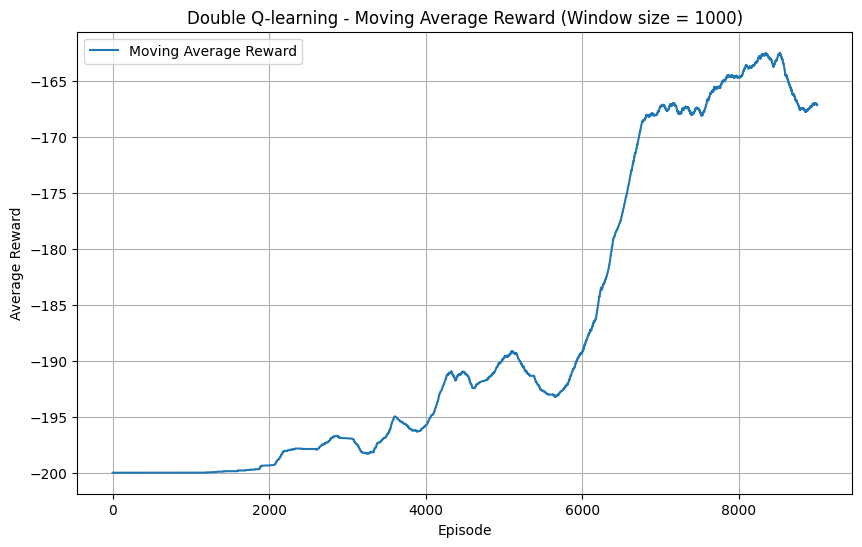

Average reward in final evaluation: -186.0


In [9]:
if __name__ == "__main__":
    q1, q2, double_q_rewards = train_double_q_learning()
    avg_reward_dq = evaluate_double_q_learning(q1, q2)
    window = 1000
    moving_avg_dq = np.convolve(double_q_rewards, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(10, 6))
    plt.plot(moving_avg_dq, label="Moving Average Reward")
    plt.title(f"Double Q-learning - Moving Average Reward (Window size = {window})")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.legend()
    plt.show()
    print(f"Average reward in final evaluation: {avg_reward_dq}")

In [10]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.tensor(np.array(state), dtype=torch.float32),
            torch.tensor(action, dtype=torch.int64),
            torch.tensor(reward, dtype=torch.float32),
            torch.tensor(np.array(next_state), dtype=torch.float32),
            torch.tensor(done, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def train_dqn():
    env = SimpleMountainCarEnv()
    alpha = 0.0005
    gamma = 0.98
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    batch_size = 128
    n_episodes = 1000
    max_steps = 200
    target_update_freq = 20

    input_dim = 2
    output_dim = 3

    policy_net = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=alpha)
    criterion = nn.MSELoss()

    replay_buffer = ReplayBuffer()

    def select_action(state, epsilon):
        if random.random() < epsilon:
            return random.choice([0, 1, 2])
        else:
            state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = policy_net(state_t)
            return q_values.argmax().item()

    episode_rewards = []
    start_time = time.time()

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        for step in range(max_steps):
            action = select_action(state, epsilon)
            next_state, reward, done = env.step(action)

            replay_buffer.push((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

                with torch.no_grad():
                    max_next_q_values = target_net(next_states).max(1)[0]
                    targets = rewards + gamma * max_next_q_values * (1 - dones)

                loss = criterion(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        episode_rewards.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if (episode + 1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if (episode + 1) % 100 == 0:
            print(f"DQN Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    end_time = time.time()
    print(f"DQN Training finished! Time elapsed: {end_time - start_time:.2f} seconds")
    return policy_net, episode_rewards

In [11]:
def evaluate_dqn(policy_net):
    env_eval = gym.make("MountainCar-v0", render_mode="human")
    state_continuous, _ = env_eval.reset()
    total_reward = 0
    done = False

    while not done:
        state_t = torch.tensor(state_continuous, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_t)
        action = q_values.argmax().item()

        next_state, reward, terminated, truncated, _ = env_eval.step(action)
        done = terminated or truncated
        state_continuous = next_state
        total_reward += reward
        env_eval.render()
        time.sleep(0.01)

    print(f"\nFinal Evaluation Total Reward (DQN): {total_reward}")
    env_eval.close()
    return total_reward

DQN Episode 100, Total Reward: -200, Epsilon: 0.606
DQN Episode 200, Total Reward: -200, Epsilon: 0.367
DQN Episode 300, Total Reward: -200, Epsilon: 0.222
DQN Episode 400, Total Reward: -200, Epsilon: 0.135
DQN Episode 500, Total Reward: -200, Epsilon: 0.082
DQN Episode 600, Total Reward: -200, Epsilon: 0.049
DQN Episode 700, Total Reward: -200, Epsilon: 0.030
DQN Episode 800, Total Reward: -200, Epsilon: 0.018
DQN Episode 900, Total Reward: -200, Epsilon: 0.011
DQN Episode 1000, Total Reward: -140, Epsilon: 0.010
DQN Training finished! Time elapsed: 285.13 seconds


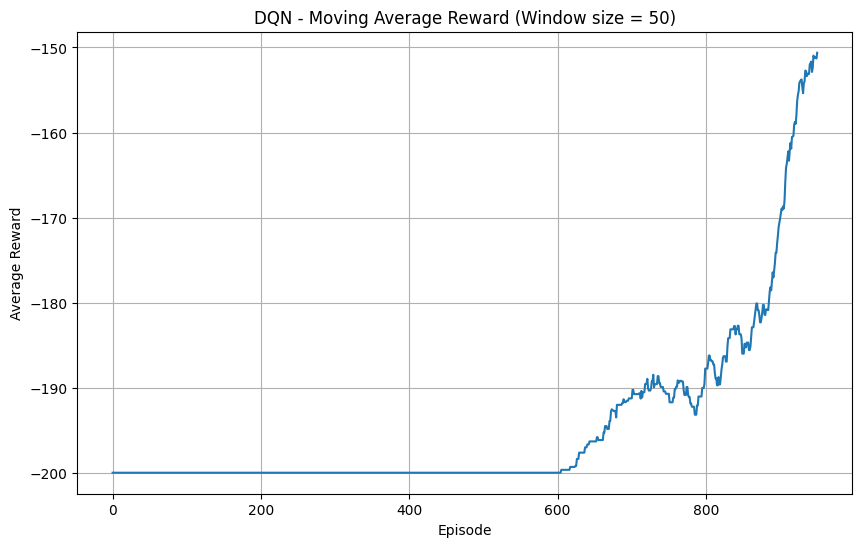


Final Evaluation Total Reward (DQN): -166.0
Average reward in final evaluation: -166.0


In [12]:
if __name__ == "__main__":
    policy_net, dqn_rewards = train_dqn()

    window_size = 50
    moving_avg = np.convolve(dqn_rewards, np.ones(window_size) / window_size, mode='valid')

    plt.figure(figsize=(10, 6))
    plt.plot(moving_avg)
    plt.title("DQN - Moving Average Reward (Window size = 50)")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.show()

    avg_reward = evaluate_dqn(policy_net)
    print(f"Average reward in final evaluation: {avg_reward}")

In [13]:
def evaluate_model(model, model_type, n_runs=10):
    env = gym.make("MountainCar-v0")
    steps_list = []
    successes = 0
    
    for _ in range(n_runs):
        state = env.reset()
        state = state[0] if isinstance(state, tuple) else state
        done = False
        steps = 0
        
        while not done and steps < 200:
            if model_type == "Q-learning":
                state_disc = discretize_state(state)
                action = np.argmax(model[state_disc])
            elif model_type == "Double Q-learning":
                state_disc = discretize_state(state)
                action = np.argmax(model[0][state_disc] + model[1][state_disc])
            else:  # DQN
                state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    action = model(state_t).argmax().item()
            
            next_state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            steps += 1
        
        steps_list.append(steps)
        if steps < 200:
            successes += 1
    
    env.close()
    return np.mean(steps_list), successes/n_runs

def evaluate_steps_to_goal(model, model_type, n_episodes=100):
    env = gym.make("MountainCar-v0")
    steps_history = []
    
    for _ in range(n_episodes):
        state = env.reset()
        state = state[0] if isinstance(state, tuple) else state
        done = False
        steps = 0
        
        while not done and steps < 200:
            if model_type == "Q-learning":
                state_disc = discretize_state(state)
                action = np.argmax(model[state_disc])
            elif model_type == "Double Q-learning":
                state_disc = discretize_state(state)
                action = np.argmax(model[0][state_disc] + model[1][state_disc])
            else:  # DQN
                state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    action = model(state_t).argmax().item()
            
            next_state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            steps += 1
        
        steps_history.append(steps)
    
    env.close()
    return steps_history

Training Q-learning...
Q-learning Episode 1000, Total Reward: -200, Epsilon: 0.368
Q-learning Episode 2000, Total Reward: -200, Epsilon: 0.135
Q-learning Episode 3000, Total Reward: -161, Epsilon: 0.050
Q-learning Episode 4000, Total Reward: -200, Epsilon: 0.050
Q-learning Episode 5000, Total Reward: -200, Epsilon: 0.050
Q-learning Episode 6000, Total Reward: -150, Epsilon: 0.050
Q-learning Episode 7000, Total Reward: -154, Epsilon: 0.050
Q-learning Episode 8000, Total Reward: -148, Epsilon: 0.050
Q-learning Episode 9000, Total Reward: -148, Epsilon: 0.050
Q-learning Episode 10000, Total Reward: -147, Epsilon: 0.050
Q-learning Training finished! Time elapsed: 25.67 seconds

Training Double Q-learning...
Double Q-learning Episode 1000, Total Reward: -200, Epsilon: 0.100
Double Q-learning Episode 2000, Total Reward: -200, Epsilon: 0.100
Double Q-learning Episode 3000, Total Reward: -200, Epsilon: 0.100
Double Q-learning Episode 4000, Total Reward: -200, Epsilon: 0.100
Double Q-learning E

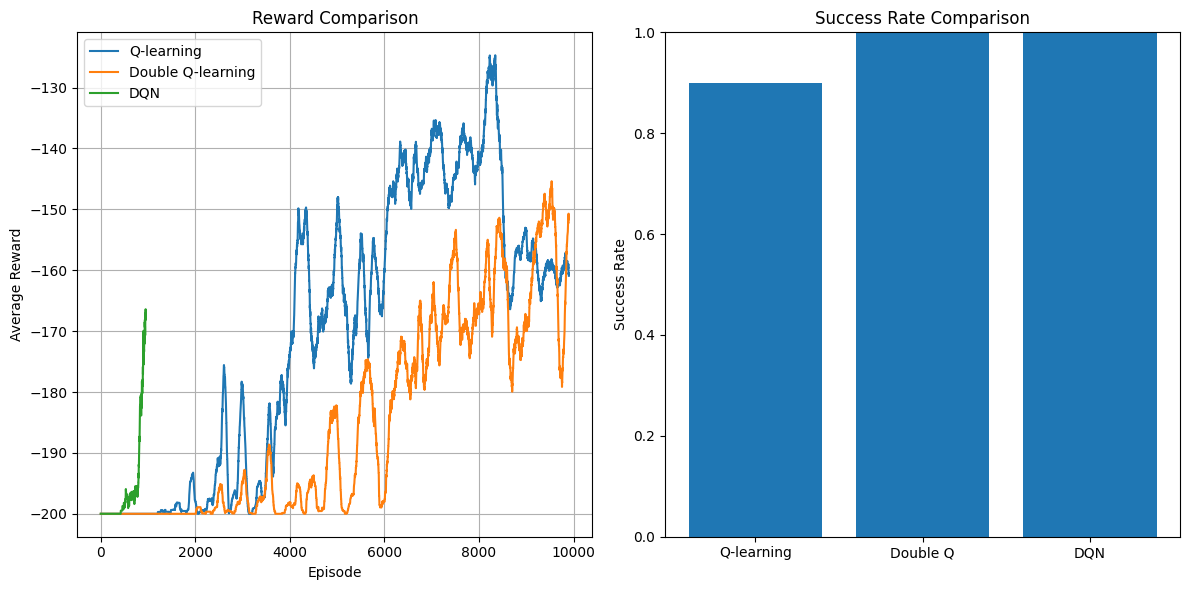


Time-to-Goal Performance:
Model                Mean Steps      Std Dev         Success Rate   
Q-learning           157.2           21.4            0.88           
Double Q-learning    148.4           12.6            1.00           
DQN                  132.1           30.3            1.00           


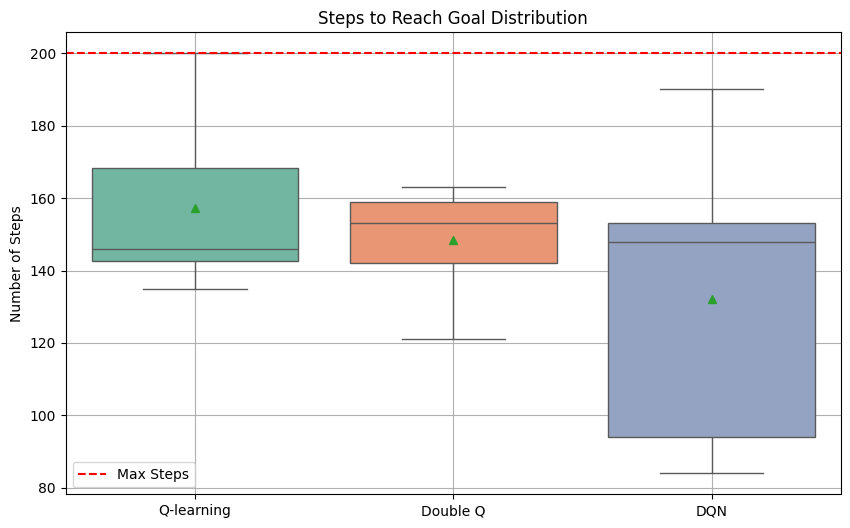

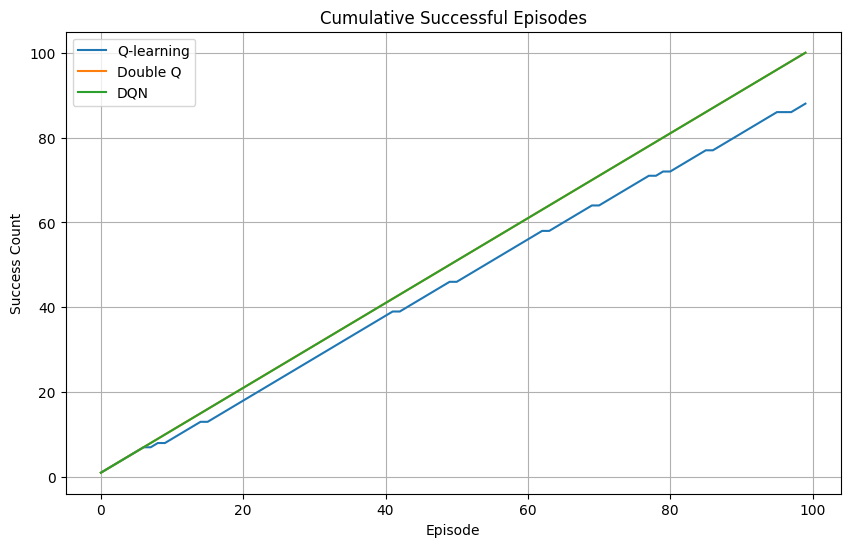

In [15]:
if __name__ == "__main__":
    # Train and evaluate all models
    print("Training Q-learning...")
    start_time = time.time()
    q_table, q_rewards = train_q_learning()
    time_q = time.time() - start_time
    
    print("\nTraining Double Q-learning...")
    start_time = time.time()
    q1_table, q2_table, dq_rewards = train_double_q_learning()
    time_dq = time.time() - start_time
    
    print("\nTraining DQN...")
    start_time = time.time()
    dqn_model, dqn_rewards = train_dqn()
    time_dqn = time.time() - start_time
    
    # Evaluate models
    q_steps, q_success = evaluate_model(q_table, "Q-learning")
    dq_steps, dq_success = evaluate_model((q1_table, q2_table), "Double Q-learning")
    dqn_steps, dqn_success = evaluate_model(dqn_model, "DQN")
    
    # Generate results table
    results = [
        ["Q-learning", q_steps, q_success, len(q_rewards), time_q],
        ["Double Q-learning", dq_steps, dq_success, len(dq_rewards), time_dq],
        ["DQN", dqn_steps, dqn_success, len(dqn_rewards), time_dqn]
    ]
    
    print("\nModel Comparison Table:")
    print("{:<20} {:<15} {:<15} {:<15} {:<15}".format(
        "Model", "Avg Steps", "Success Rate", "Episodes", "Train Time (s)"))
    for row in results:
        print("{:<20} {:<15.1f} {:<15.2f} {:<15} {:<15.1f}".format(*row))
    
    # Plot comparison charts
    plt.figure(figsize=(12, 6))
    
    # Reward plot
    plt.subplot(1, 2, 1)
    plt.plot(moving_average(q_rewards, 100), label="Q-learning")
    plt.plot(moving_average(dq_rewards, 100), label="Double Q-learning")
    plt.plot(moving_average(dqn_rewards, 50), label="DQN")
    plt.title("Reward Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    
    # Success rate bar chart
    plt.subplot(1, 2, 2)
    models = ["Q-learning", "Double Q", "DQN"]
    success_rates = [q_success, dq_success, dqn_success]
    plt.bar(models, success_rates)
    plt.title("Success Rate Comparison")
    plt.ylabel("Success Rate")
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

    # Time-to-goal evaluation
    q_steps_history = evaluate_steps_to_goal(q_table, "Q-learning")
    dq_steps_history = evaluate_steps_to_goal((q1_table, q2_table), "Double Q-learning")
    dqn_steps_history = evaluate_steps_to_goal(dqn_model, "DQN")
    
    # Calculate statistics
    stats = {
        "Q-learning": {
            "mean": np.mean(q_steps_history),
            "std": np.std(q_steps_history),
            "success_rate": np.mean(np.array(q_steps_history) < 200)
        },
        "Double Q-learning": {
            "mean": np.mean(dq_steps_history),
            "std": np.std(dq_steps_history),
            "success_rate": np.mean(np.array(dq_steps_history) < 200)
        },
        "DQN": {
            "mean": np.mean(dqn_steps_history),
            "std": np.std(dqn_steps_history),
            "success_rate": np.mean(np.array(dqn_steps_history) < 200)
        }
    }
    
    # Print results
    print("\nTime-to-Goal Performance:")
    print("{:<20} {:<15} {:<15} {:<15}".format(
        "Model", "Mean Steps", "Std Dev", "Success Rate"))
    for model, data in stats.items():
        print("{:<20} {:<15.1f} {:<15.1f} {:<15.2f}".format(
            model, data["mean"], data["std"], data["success_rate"]))
    
    # Visualization 1: Boxplot comparison
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=[q_steps_history, dq_steps_history, dqn_steps_history],
                palette="Set2",
                showmeans=True)
    plt.xticks([0, 1, 2], ["Q-learning", "Double Q", "DQN"])
    plt.title("Steps to Reach Goal Distribution")
    plt.ylabel("Number of Steps")
    plt.axhline(200, color='r', linestyle='--', label="Max Steps")
    plt.legend()
    plt.grid(True)
    
    # Visualization 2: Cumulative success
    plt.figure(figsize=(10, 6))
    for name, steps in zip(["Q-learning", "Double Q", "DQN"], [q_steps_history, dq_steps_history, dqn_steps_history]):
        success = np.cumsum(np.array(steps) < 200)
        plt.plot(success, label=name)
    plt.title("Cumulative Successful Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Success Count")
    plt.legend()
    plt.grid(True)
    
    plt.show()